In [ ]:
#Install libraries
#! pip install ../requirements.txt

In [109]:
#Importing libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,  LabelEncoder,OneHotEncoder
from sklearn.model_selection import GridSearchCV,cross_val_score,train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.cluster import KMeans
from prince import MCA

# Specify your custom color palette
custom_palette = ['#D6B268', '#2255A4', '#B3E3EE']
color_cont='tealrose_r'
color_cont=px.colors.qualitative.Plotly[0:6]


In [110]:
df=pd.read_csv(r"/kaggle/input/cricket/IndianCricketTeam.csv")
df.head()

,Match ID,Player ID,Player,Runs Scored in Match,Wickets Taken in Match,Runs Conceded in Match,Catches Taken in Match,Stumpings Made in Match,Opposition,Ground,...,Total Catches Taken,Total Stumpings Made,Batting Hand,Bowling Arm,Bowling Style,Result,Toss,Day/Night Match,Home/Away/Neutral,Toss Decision
0,648,25,AB Agarkar,2,2.0,39.0,0.0,0.0,Pakistan,Brisbane,...,38.0,0.0,Right Hand,Right Arm,Pace Bowler,lost,won,Night,Neutral,Bat
1,647,25,AB Agarkar,6,1.0,47.0,1.0,0.0,Australia,Melbourne,...,38.0,0.0,Right Hand,Right Arm,Pace Bowler,lost,lost,Night,Away,Field
2,643,25,AB Agarkar,0,0.0,60.0,0.0,0.0,Pakistan,Perth,...,38.0,0.0,Right Hand,Right Arm,Pace Bowler,lost,lost,Night,Neutral,Field
3,1,25,AB Agarkar,NaN,1.0,39.0,1.0,0.0,Australia,Perth,...,38.0,0.0,Right Hand,Right Arm,Pace Bowler,lost,won,Day,Away,Bat
4,2,25,AB Agarkar,NaN,0.0,55.0,1.0,0.0,South Africa,Kochi,...,38.0,0.0,Right Hand,Right Arm,Pace Bowler,won,lost,Day,Home,Field


## 1) Handling Null Values

In [111]:
df.isna().sum()

Match ID                      0
Player ID                     0
Player                        0
Runs Scored in Match       1696
Wickets Taken in Match     3120
Runs Conceded in Match     3120
Catches Taken in Match      110
Stumpings Made in Match     110
Opposition                    0
Ground                        0
Start Date                    0
Not Out                       0
Did Not Bat                   0
Total Runs Scored            21
Batting Avg                  55
Batting Strike Rate          25
Total Centuries              21
Total Half Centuries         21
4s                           21
6s                           21
Total Wickets Taken         907
Best Bowling Figures       1276
Bowling Avg                1276
Best Economy Rate           907
Bowling Strike Rate        1276
Total Matches Played          0
Total Dismissals Made         0
Total Catches Taken           0
Total Stumpings Made          0
Batting Hand                  0
Bowling Arm                   0
Bowling 

Note: For some players, some variable values may be nulls. For eg. players can be batsmen and fielders, but they never bowled. We can fill the null values with 0.

## 2) Numerical Vs Categorical Variables
Let's check out the numerical and categorical variables in the dataset (excluding Match ID and Player ID which are primary keys). Also, we remove Player Name, Ground in which match was played, Opposition Team and Best Bowling Figures and place it in metadata instead. 

In [112]:
ids=['Match ID','Player ID']
print("Table IDs are: ", ids)
## Numerical Columns
num=df.select_dtypes(['int','float'])
num=num.drop(columns=ids).columns
print("Numerical Columns are: ", num.to_list())

metadata= ['Player','Opposition','Ground','Start Date','Best Bowling Figures']
print("Meta Data Columns are: ",metadata)
##Categorical Columns
cat=df.select_dtypes('O').drop(columns=metadata).columns
print("Categorical Columns are: ", cat.to_list())



Table IDs are:  ['Match ID', 'Player ID']
Numerical Columns are:  ['Wickets Taken in Match', 'Runs Conceded in Match', 'Catches Taken in Match', 'Stumpings Made in Match', 'Total Runs Scored', 'Batting Avg', 'Batting Strike Rate', 'Total Centuries', 'Total Half Centuries', '4s', '6s', 'Total Wickets Taken', 'Bowling Avg', 'Best Economy Rate', 'Bowling Strike Rate', 'Total Matches Played', 'Total Dismissals Made', 'Total Catches Taken', 'Total Stumpings Made']
Meta Data Columns are:  ['Player', 'Opposition', 'Ground', 'Start Date', 'Best Bowling Figures']
Categorical Columns are:  ['Runs Scored in Match', 'Batting Hand', 'Bowling Arm', 'Bowling Style', 'Result', 'Toss', 'Day/Night Match', 'Home/Away/Neutral', 'Toss Decision']


# Feature Engineering

Some numerical variables like *Total Runs Scored* and *Total Wickets Taken* show the no.s of runs and wickets they have taken. But it may not be a robust way to judge a player's ability to score runs or take wickets. Therefore, we can add some new variables like

1. **CenturiesToFifties Ratio**:
   - This variable calculates the ratio of total centuries to total half centuries. It can help assess a player's ability to convert fifties (50 runs) into centuries (100 runs). A high ratio might indicate a more consistent performance in reaching the milestone of 100 runs.

2. **Runs_Scored_per_Boundary**:
   - This variable calculates the average runs scored per boundary hit (either 4s or 6s). It provides insights into a player's boundary-hitting ability and scoring efficiency.

3. **Runs Scored per Match**:
   - This variable calculates the average runs scored per match. It helps to understand a player's average contribution to their team's score in each match, which is valuable for evaluating batting performance.

4. **Wickets Taken per Match**:
   - This variable calculates the average wickets taken per match. It indicates a player's bowling performance in terms of wicket-taking ability and consistency.

5. **Bowling Economy Rate per Wicket**:
   - This variable calculates the economy rate per wicket taken. It provides insights into how economically a bowler takes wickets. A lower value may indicate a more efficient bowler.

6. **Dismissals-to-Catches Ratio**:
   - This variable calculates the ratio of total dismissals made to catches taken. It helps assess a player's fielding skills and their ability to contribute to the team's fielding performance. A higher ratio may indicate a greater involvement in dismissals other than catches.

These new variables offer a more comprehensive view of player performance in cricket by considering various aspects of batting, bowling, and fielding. They can be useful for making comparisons, identifying trends, and making informed decisions about player selection or strategies in the sport. Additionally, they can be used for data visualization and further statistical analysis to gain deeper insights into player performance.

In [113]:

##Creating variable Centuries To Fifties Ratio
df['CenturiesToFifties Ratio'] = df['Total Centuries'] / df['Total Half Centuries']
df['Runs_Scored_per_Boundary'] = df['Total Runs Scored'] / (df['4s'] + df['6s'])

df['Runs Scored per Match']=df['Total Runs Scored']/df['Total Matches Played']
df['Wickets Taken per Match'] = df['Total Wickets Taken'] / df['Total Matches Played']
# Calculate Bowling Economy Rate per Wicket
df['Bowling Economy Rate per Wicket'] = df['Bowling Avg'] / df['Total Wickets Taken']
# Calculate the Dismissals-to-Catches Ratio
df['Dismissals-to-Catches Ratio'] = df['Total Dismissals Made'] / df['Total Catches Taken']
df['Batting to Bowling Performance Ratio'] = df['Batting Avg'] / df['Bowling Avg']


# Replace infinite values with 0
df.replace([np.inf, -np.inf], 0, inplace=True)



In [114]:
# Define the list of columns you want to include in the 'players' DataFrame
selected_columns = ['Player ID', 'Player', 'Batting Avg', 'Bowling Avg','Total Matches Played', 'Total Runs Scored', 'Total Wickets Taken', '4s', '6s', 'Total Catches Taken', 'Total Stumpings Made', 'Bowling Economy Rate per Wicket', 'Wickets Taken per Match','CenturiesToFifties Ratio','Runs_Scored_per_Boundary','Dismissals-to-Catches Ratio','Batting to Bowling Performance Ratio','Batting Strike Rate','Bowling Strike Rate','Total Centuries','Total Half Centuries']

# Create the 'players' DataFrame by selecting the specified columns from 'df'
df_players = df[selected_columns].groupby(['Player ID','Player']).mean().reset_index()

df_players.head()


,Player ID,Player,Batting Avg,Bowling Avg,Total Matches Played,Total Runs Scored,Total Wickets Taken,4s,6s,Total Catches Taken,...,Bowling Economy Rate per Wicket,Wickets Taken per Match,CenturiesToFifties Ratio,Runs_Scored_per_Boundary,Dismissals-to-Catches Ratio,Batting to Bowling Performance Ratio,Batting Strike Rate,Bowling Strike Rate,Total Centuries,Total Half Centuries
0,0,V Kohli,58.16,166.75,286.0,13437.0,4.0,1255.0,148.0,150.0,...,41.687500,0.013986,0.695652,9.577334,1.000000,0.348786,93.69,161.0,48.0,69.0
1,1,MS Dhoni,50.23,31.00,347.0,10599.0,1.0,809.0,222.0,318.0,...,31.000000,0.002882,0.123288,10.280310,1.377358,1.620323,87.13,36.0,9.0,73.0
2,2,RG Sharma,49.16,64.37,256.0,10423.0,8.0,961.0,309.0,92.0,...,8.046250,0.031250,0.584906,8.207087,1.000000,0.763710,91.40,74.1,31.0,53.0
3,3,SR Tendulkar,46.70,41.09,234.0,9855.0,76.0,1162.0,84.0,65.0,...,0.540658,0.324786,0.480769,7.909310,1.000000,1.136530,85.75,46.2,25.0,52.0
4,4,Yuvraj Singh,36.47,38.42,301.0,8609.0,110.0,896.0,153.0,93.0,...,0.349273,0.365449,0.269231,8.206864,1.000000,0.949245,87.43,45.3,14.0,52.0


# Exploratory Data Analysis
To gain further insights about the player statistics (eg. runs scores per boundary,batting hand, bowling style) and match conditions

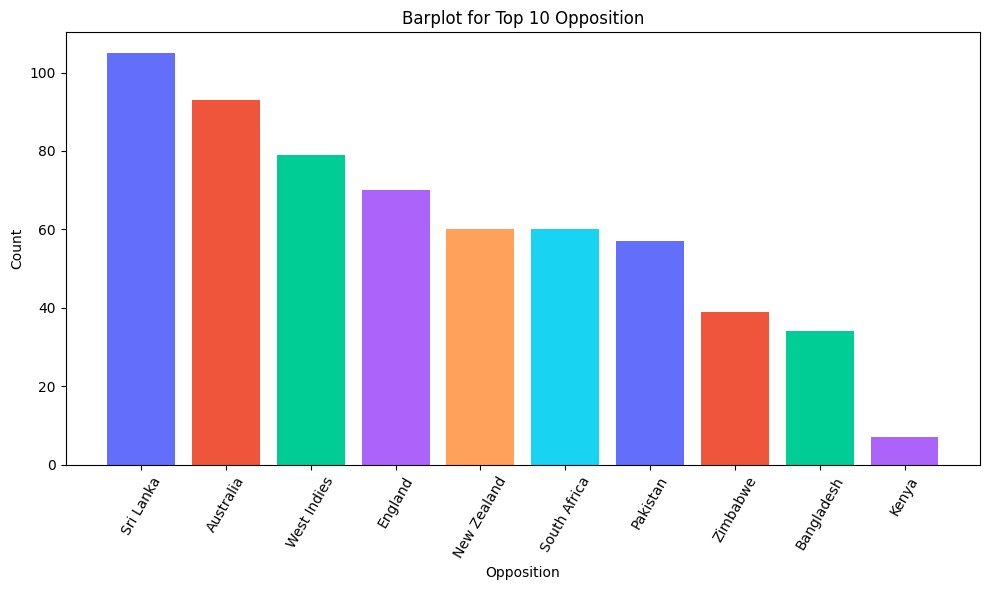

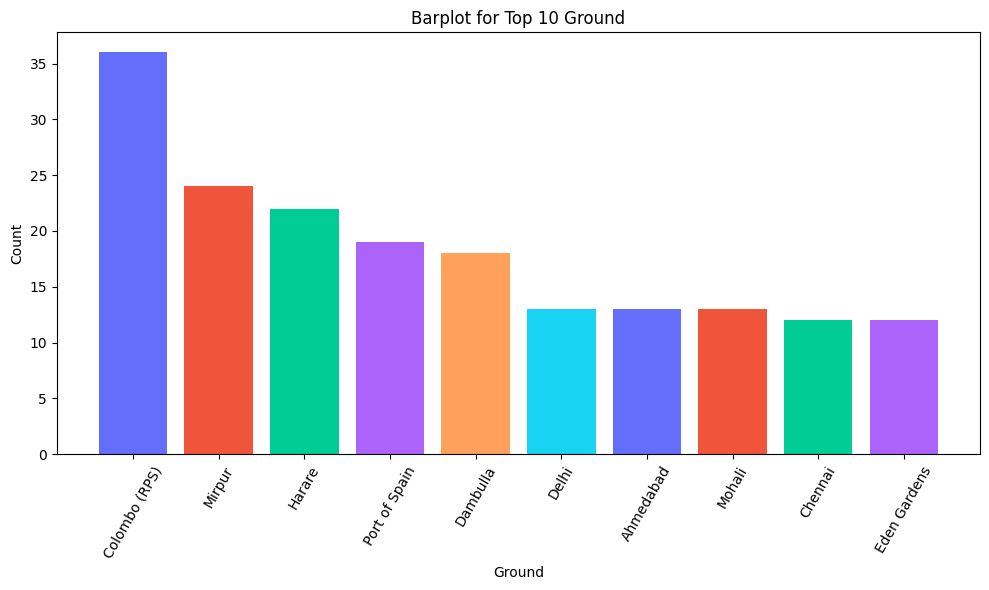

In [115]:
# Specify the columns to create barplots for
cols = ['Match ID','Opposition', 'Ground'] 

df_matches = df[cols].drop_duplicates()

# Create barplots for each column
for col in cols:
    if col == 'Match ID':
        continue
    # Count unique values for the current category
    value_counts=df_matches[col].value_counts().nlargest(10)
    
    plt.figure(figsize=(10, 6))
    plt.title(f'Barplot for Top 10 {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.bar(value_counts.index, value_counts, color=color_cont)  # Use Cobalt Blue as the bar color
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

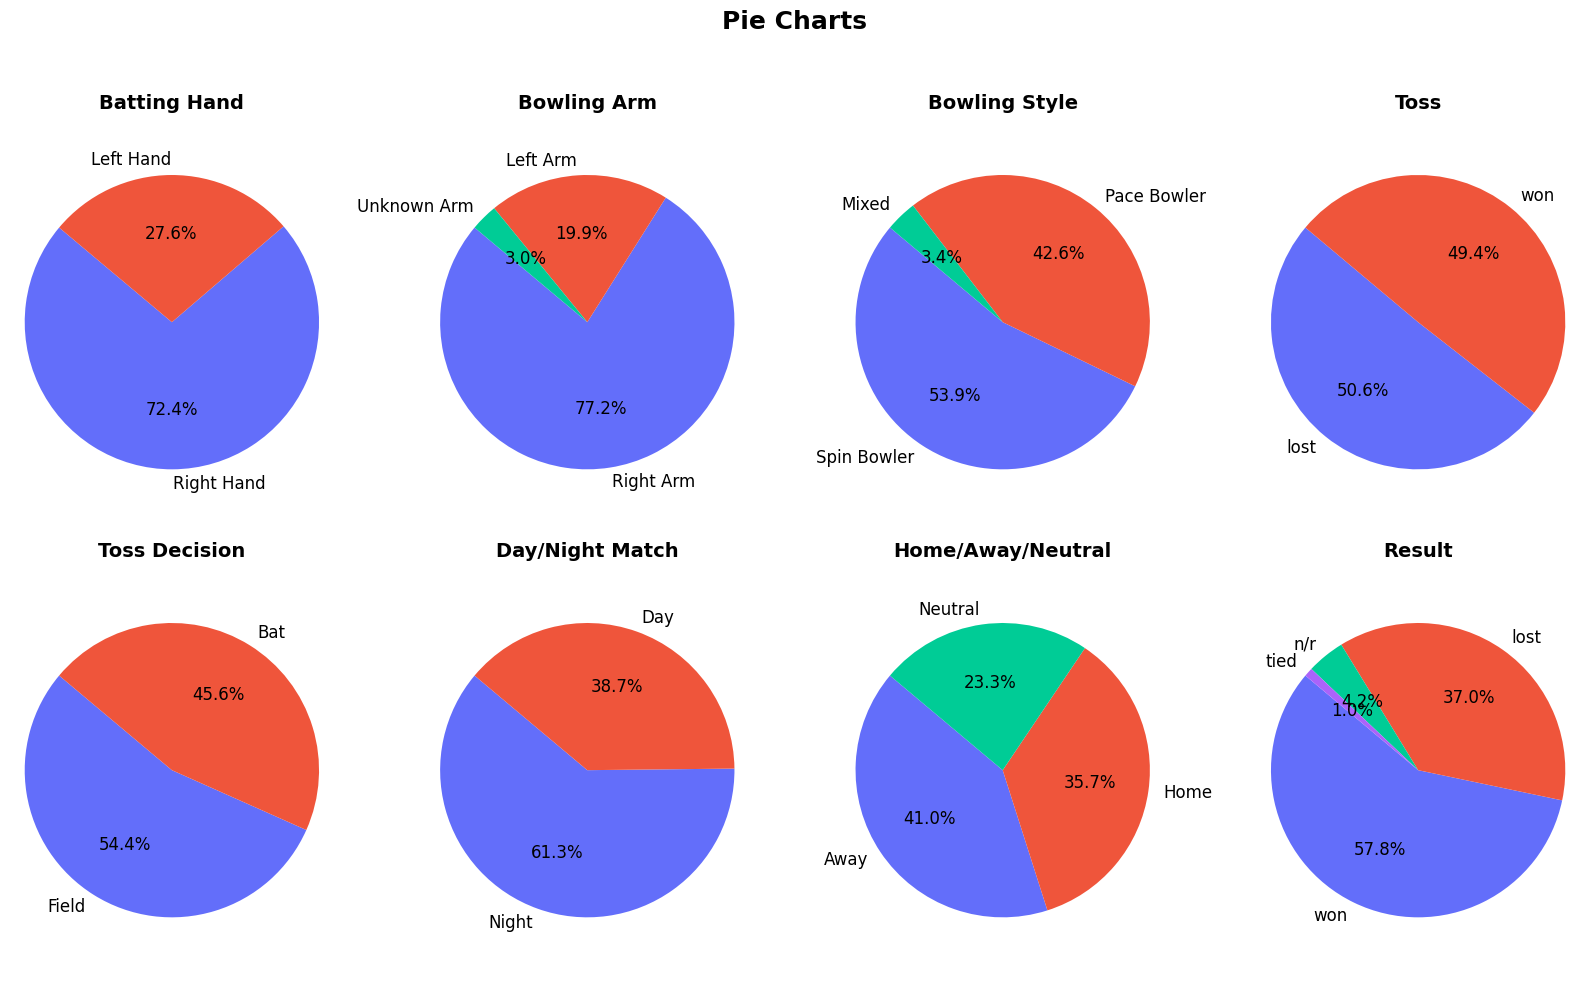

In [116]:
# Specify the columns for pie charts
cols = ['Batting Hand', 'Bowling Arm', 'Bowling Style', 'Toss', 'Toss Decision', 'Day/Night Match', 'Home/Away/Neutral','Result']

# Create a subplot with multiple pie charts
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
fig.suptitle('Pie Charts', fontsize=18, fontweight='bold')
fig.patch.set_facecolor('white')  # Set the background color of the entire figure to white

for i, col in enumerate(cols):
    row, col_num = divmod(i, 4)
    ax = axes[row, col_num]

    # Count the number of occurrences for each category
    value_counts = df[col].value_counts()

    # Create a pie chart with your custom colors
    ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140, colors=color_cont,textprops={'fontsize': 12})

    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    ax.set_title(col, fontweight='bold', fontsize=14)


# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

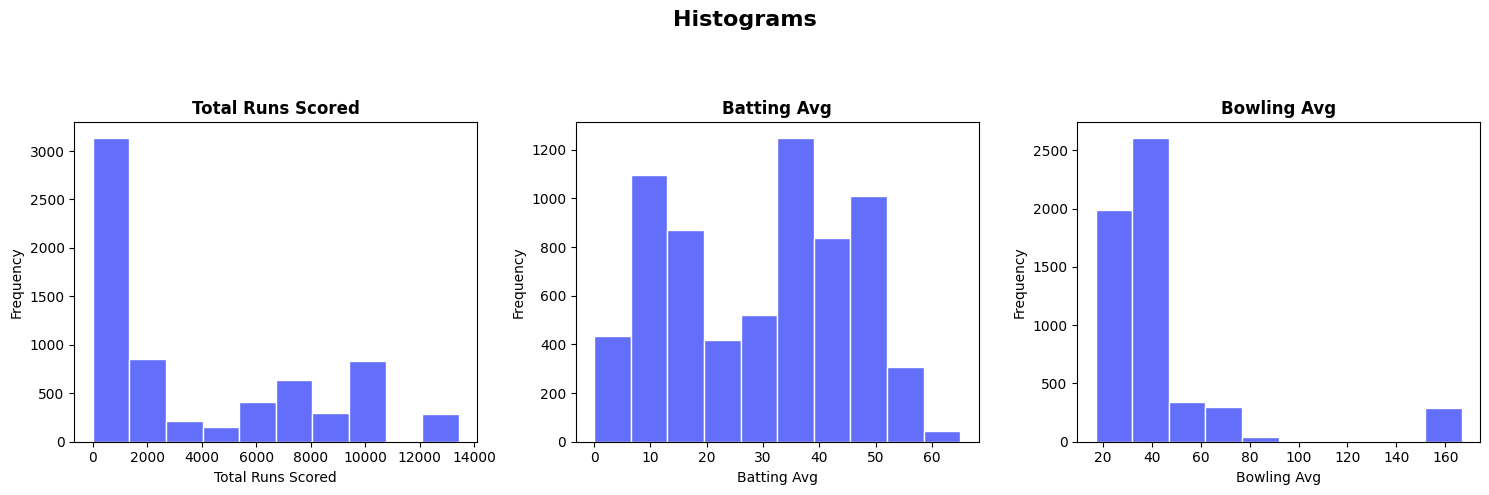

In [117]:
# Create subplots for histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Histograms', fontsize=16, fontweight='bold')

# Specify the columns for histograms
columns = ['Total Runs Scored', 'Batting Avg', 'Bowling Avg']

# Create histograms for each column
for i, col in enumerate(columns):
    ax = axes[i]
    ax.hist(df[col], bins=10, color=color_cont[:1], edgecolor='white')
    ax.set_title(col, fontsize=12, fontweight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

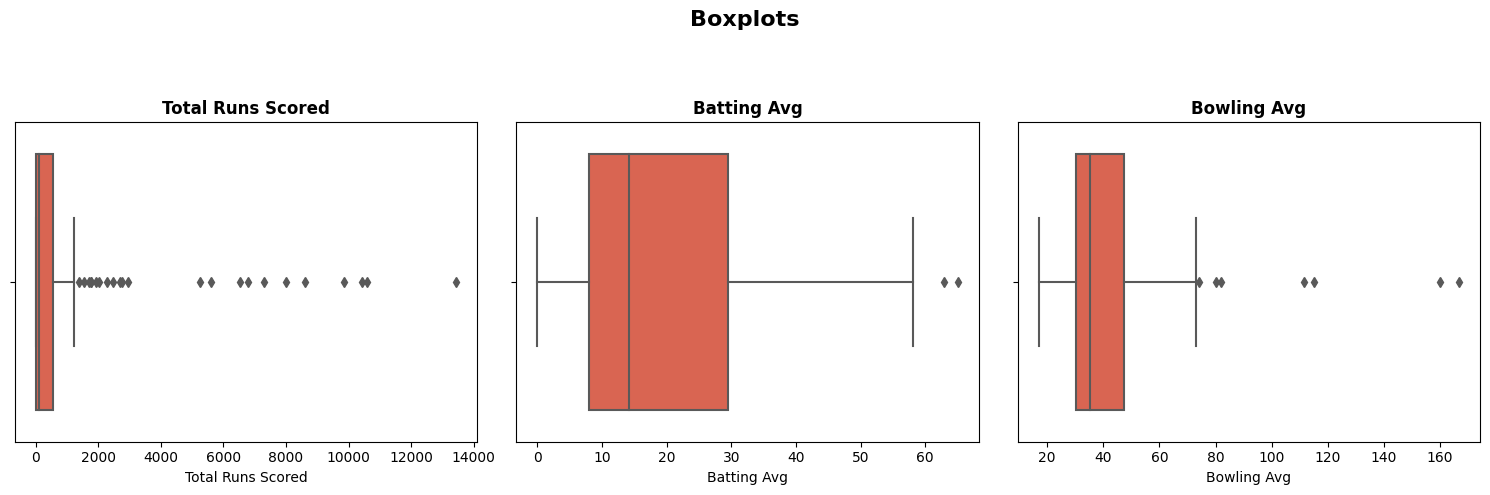

In [118]:
# Create subplots for boxplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Boxplots', fontsize=16, fontweight='bold')

# Specify the numerical columns for boxplots
columns = ['Total Runs Scored', 'Batting Avg', 'Bowling Avg']

# Create boxplots for each column using Seaborn
for i, col in enumerate(columns):
    ax = axes[i]
    sns.boxplot(data=df_players, x=col, ax=ax, color=color_cont[1])
    ax.set_title(col, fontsize=12, fontweight='bold')

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()



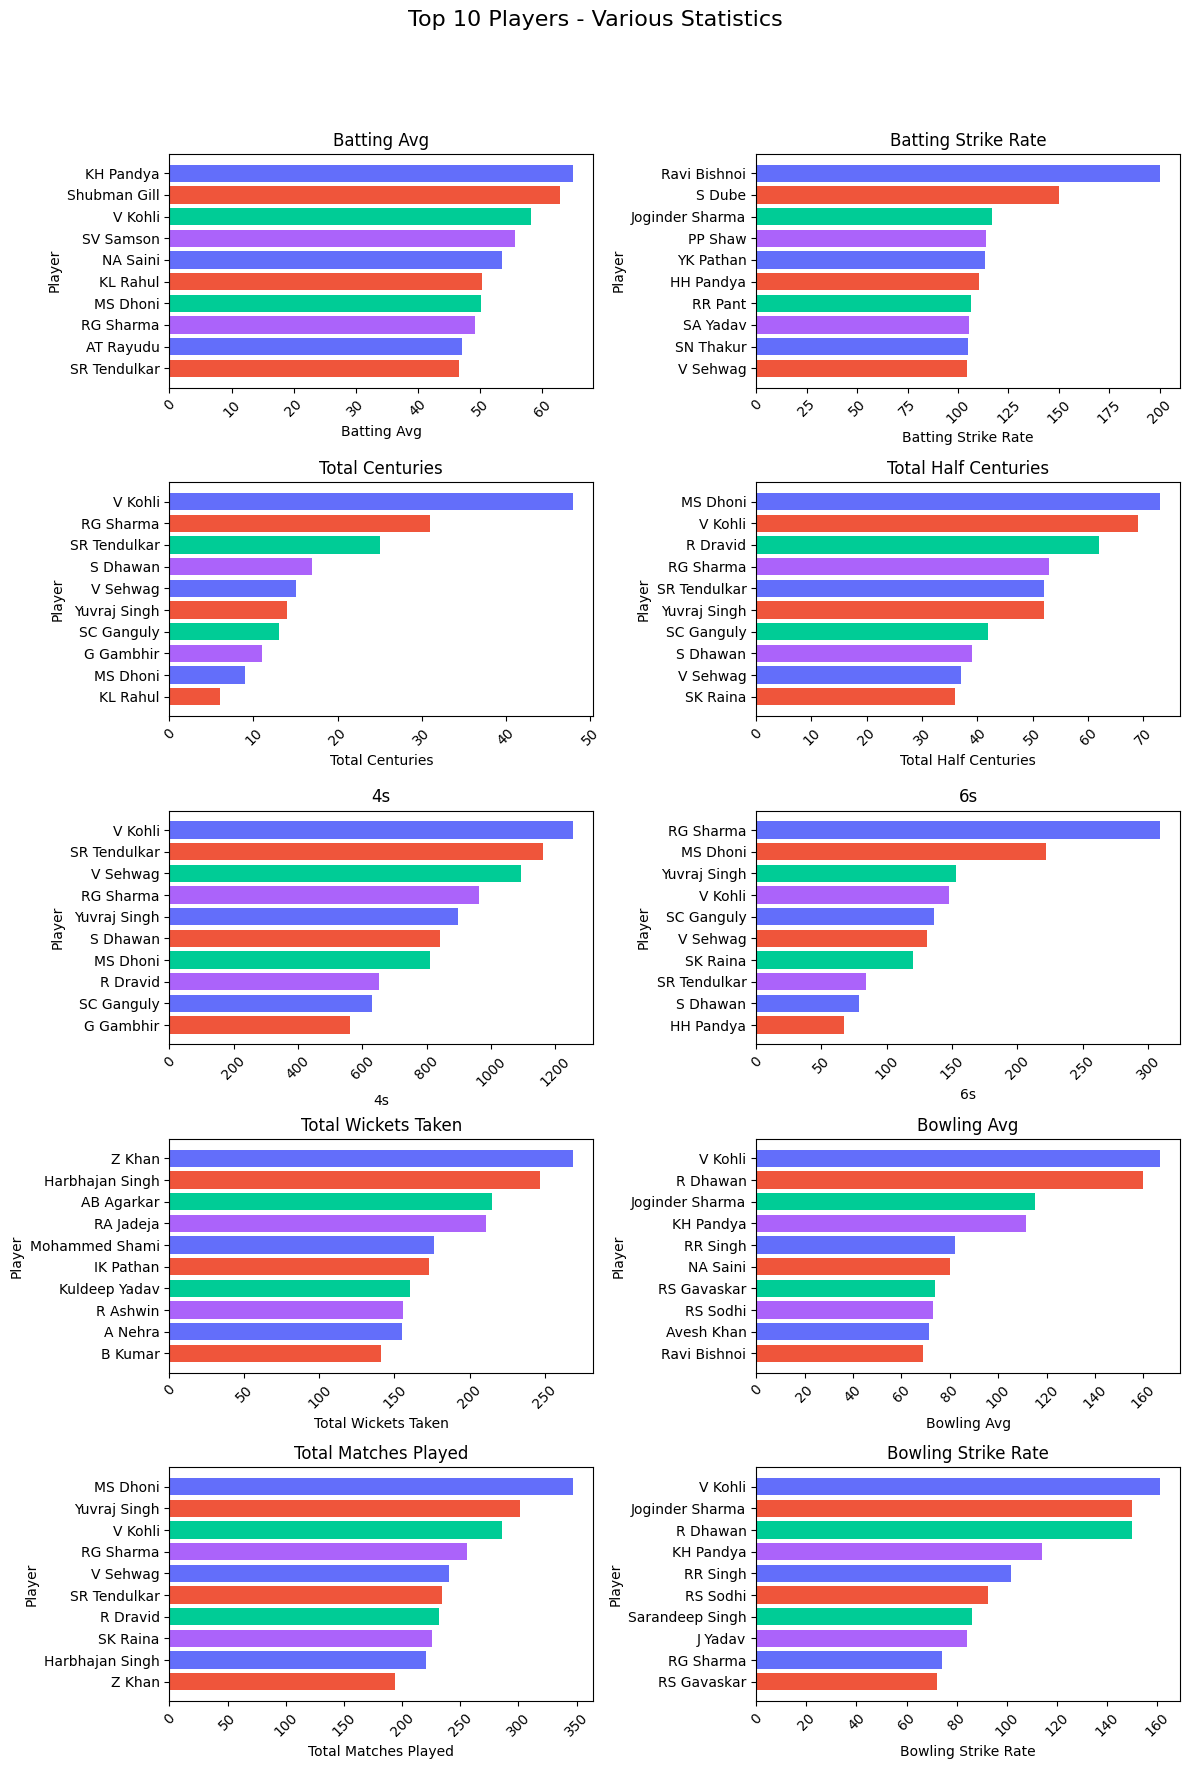

In [119]:

# List of statistics columns to visualize
statistics = ['Batting Avg', 'Batting Strike Rate', 'Total Centuries', 'Total Half Centuries',
              '4s', '6s', 'Total Wickets Taken', 'Bowling Avg', 'Total Matches Played', 'Bowling Strike Rate']

# Number of rows and columns for subplots
num_rows = 5
num_cols = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 18))
fig.suptitle('Top 10 Players - Various Statistics', fontsize=16)

# Flatten the 2D array of subplots for easy iteration
axes = axes.flatten()

# Loop through the statistics and create a barplot for each
for i, statistic in enumerate(statistics):
    top_10_players = df_players.nlargest(10, statistic).sort_values(by=statistic,ascending=False)

    ax = axes[i]
    ax.barh(top_10_players['Player'], top_10_players[statistic], color=px.colors.qualitative.Plotly[:4])
    ax.set_title(statistic)
    ax.set_xlabel(statistic)
    ax.set_ylabel('Player')
    ax.invert_yaxis()  # Reverse the order to show the top player at the top
    ax.tick_params(axis='x', rotation=45)

# Hide any remaining empty subplots
for i in range(len(statistics), num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()



In [120]:
color_cont = px.colors.qualitative.Plotly[:4]

In [121]:

# Create the side-by-side bar chart using Plotly
fig = px.bar(
    df_players.loc[(df_players['Batting Avg'].isna()==False) & (df_players['Batting Avg']!=0) ],
    x='Player',
    y=['Batting Avg', 'Bowling Avg'],
    title='Comparative Analysis - Batting vs. Bowling',
    labels={'value': 'Average'}
)

# Customize the layout (optional)
fig.update_layout(
    xaxis_title='Player',
    yaxis_title='Average',
)

# Show the plot
fig.show()


In [122]:

top_10_players = df_players.sort_values(by='CenturiesToFifties Ratio', ascending=False).head(10)



# Create a bar chart for the top 10 players with the highest ratios
fig = px.bar(
    top_10_players, 
    x='Player',  # X-axis: Player names
    y='CenturiesToFifties Ratio',  # Y-axis: Average Centuries-to-Half-Centuries Ratio
    labels={'CenturiesToFifties Ratio': 'Average Centuries-to-Half-Centuries Ratio'},
    title='Top 10 Players with the Highest Average Centuries-to-Half-Centuries Ratio'
)

# Customize the layout
fig.update_layout(
    xaxis_title='Player',
    yaxis_title='Average Centuries-to-Half-Centuries Ratio',
)

# Show the plot
fig.show()


In [123]:
def player_radar_chart(data, player_name,radar_columns):
    player_data = data[data['Player'] == player_name]

    # Create a DataFrame with the selected columns
    radar_data = player_data[radar_columns]

    # Scale the data to a 0-100 range
    min_values = data[radar_columns].min()
    max_values = data[radar_columns].max()
    scaled_data = 100 * (radar_data - min_values) / (max_values - min_values)

    # Create the radar chart using Plotly
    fig = px.line_polar(
        scaled_data, 
        r=scaled_data.values[0],  # Values for the radar chart
        theta=radar_columns,
        line_close=True,
        color_discrete_sequence=color_cont)
    # Customize colors and style
    fig.update_traces(fill='toself', marker=dict(size=8))
    # Set the title
    fig.update_layout(
        title=f'Radar Chart for All-Round Performance of {player_name}',
        polar=dict(
            radialaxis=dict(visible=True, range=[0, 100], showticklabels=True),
        )
    )

    # Show the radar chart
    fig.show()

df_players.fillna(0,inplace=True)
# Select the relevant columns for the radar chart
radar_columns = [
    'Batting Avg',
    'Batting Strike Rate',
    'Total Stumpings Made',
    'Total Wickets Taken',
    'Total Catches Taken',
    'Bowling Avg'
]




In [124]:
# Filter the data for a specific player (replace 'PlayerName' with the player's name)
player_name = 'MS Dhoni'

player_radar_chart(df_players, player_name,radar_columns)

In [125]:
player_radar_chart(df_players, 'V Kohli',radar_columns)

In [126]:
player_radar_chart(df_players, 'SR Tendulkar',radar_columns)

In [127]:
player_radar_chart(df_players, 'RG Sharma',radar_columns)

In [128]:



# Sort the data to get the top 10 players
top_10_players = df_players.sort_values(by='Wickets Taken per Match', ascending=False).head(10)

# Create a bar chart using Plotly
fig = px.bar(
    top_10_players,
    x='Player',
    y='Wickets Taken per Match',
    title='Top 10 Players by Wickets Taken per Match',
    labels={'Player': 'Player Name', 'Wickets Taken per Match': 'Average Wickets per Match'}
)

# Show the plot
fig.show()


In [129]:

# Group the data by 'Bowling Style' and count the number of players for each style
results_counts = df['Result'].value_counts().reset_index()
results_counts.columns = ['Result', 'Count']

# Create a pie chart using Plotly
fig = px.pie(results_counts,
             names='Result',
             values='Count',
             title='World Cup Matches Results Distribution',
             labels={'Bowling Style': 'Bowling Style'}
            )

# Show the plot
fig.show()


# Feature Encoding/Scaling

In [130]:

df_actual=df.copy()
df = df.loc[df['Result'].isin(['won','lost'])] #Ignore tied matches
# Convert 'Toss' to a binary variable (0 for Lost, 1 for Won)
df['Toss'] = df['Toss'].apply(lambda x: 0 if x == 'lost' else 1)

# Convert 'Day/Night Match' to a binary variable (0 for Day, 1 for Night)
df['Day/Night Match'] = df['Day/Night Match'].apply(lambda x: 0 if x == 'Day' else 1)

# Convert 'Home/Away/Neutral' to a binary variable (0 for Home, 1 for Away, 2 for Neutral)
df['Home/Away/Neutral'] = df['Home/Away/Neutral'].apply(lambda x: 0 if x == 'Home' else (1 if x == 'Away' else 2))

df['Result'] = df['Result'].apply(lambda x: 1 if x == 'won' else (0 if x == 'lost' else 2))
#df['Runs Scored in Match']=df['Runs Scored in Match'].fillna(0).astype(int)
df['Runs Scored in Match'] = df['Runs Scored in Match'].replace({'sub':np.nan}).fillna(0).astype(int)

# Clustering Analysis

In [131]:


# Choose the number of clusters (e.g., 3 for Batsmen, All-rounders, Bowlers)
n_clusters = 4

# Create a subset of the dataset
df_subset = df_players[['Player ID', 'Player', 'Batting Avg', 'Bowling Avg','Total Catches Taken']].fillna(0)

# Group by unique player IDs and calculate the mean
df_subset = df_subset.groupby(['Player ID','Player']).mean().reset_index()

df_subset = df_subset[df_subset['Player'].isin(['MS Dhoni'])==0]    ##Removing outlier players from clustering analysis

# Initialize and fit the K-Means model
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(df_subset[['Batting Avg', 'Bowling Avg','Total Catches Taken']])

# Add cluster labels to the original DataFrame
df_subset['CricketerTypeCluster'] = kmeans.labels_


# Create a scatter plot with hover text (player name)
fig = px.scatter(df_subset, x='Batting Avg', y='Bowling Avg', color='CricketerTypeCluster', size='Total Catches Taken',color_continuous_scale=color_cont,
                 title='Player Classification into Batsmen, Bowlers and All-rounders',
                 labels={'Player':'Player','Batting Avg': 'Batting Avg', 'Bowling Avg': 'Bowling Avg'},text='Player')

# Set hover text to player names
fig.update_traces(textfont=dict(color='rgba(0,0,0,0)')) 
# Add the 'BowlingCluster' column to 'df_players' based on the 'Player ID' to match players
df_players['CricketerTypeCluster'] = df_players['Player ID'].map(df_subset.set_index('Player ID')['CricketerTypeCluster'])

df_players.loc[df_players['Player'].isin(['MS Dhoni','V Kohli']),'CricketerTypeCluster'] = 1    ##Put outlier in cluster 2 (bowling)
df_players.loc[df_players['CricketerTypeCluster']==3,'CricketerTypeCluster'] = 2 
# Show the plot
fig.show()

cricketer_type_cluster={2:'Batsmen',0:'Bowlers',1:'All-rounders'}


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [132]:

# Playing Style Clusters 1: Aggressive and Conservative
n_clusters_style = 2  # Aggressive and Conservative
df_subset = df_players[['Player ID', 'Player', 'Batting Strike Rate', 'Bowling Strike Rate']].fillna(0)

df_subset = df_subset[df_subset['Player']!='YK Pathan']    ##Removing outlier from clustering analysis
kmeans_style = KMeans(n_clusters=n_clusters_style, random_state=0)
df_subset['StyleCluster'] = kmeans_style.fit_predict(df_subset[['Batting Strike Rate', 'Bowling Strike Rate']])


#Create scatter plots for Playing Style Clusters

# Playing Style Clusters 1: Aggressive and Conservative
fig_style = px.scatter(df_subset, x='Batting Strike Rate', y='Bowling Strike Rate', color='StyleCluster',color_continuous_scale=color_cont[0:2],
                 title='Playing Style Clusters: Aggressive and Conservative Players',
                 labels={'Player': 'Player', 'Batting Strike Rate': 'Batting Strike Rate', 'Bowling Strike Rate': 'Bowling Strike Rate'},
                 text='Player')


df_players['StyleCluster'] = df_players['Player ID'].map(df_subset.set_index('Player ID')['StyleCluster'])
df_players.loc[df_players['Player']=='YK Pathan','StyleCluster'] = 1    ##Put outlier in cluster 1 (aggressive player)


#
# Adjust text opacity to make it transparent
fig_style.update_traces(textfont=dict(color='rgba(0,0,0,0)'))  # Set text color to transparent
# Show the plot
fig_style.show()

style_cluster= {0:'Aggressive',1:'Conservative'}


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [133]:
# Playing Style Clusters 2: Boundary-Hitting Specialists
n_clusters_boundary = 2  # Boundary-Hitting Specialists
df_subset = df_players[['Player ID', 'Player', '4s', '6s']].fillna(0)


kmeans_boundary = KMeans(n_clusters=n_clusters_boundary, random_state=0)
df_subset['BoundaryCluster'] = kmeans_boundary.fit_predict(df_subset[['4s', '6s']])

# Playing Style Clusters 2: Boundary-Hitting Specialists
fig_boundary = px.scatter(df_subset, x='4s', y='6s', color='BoundaryCluster',color_continuous_scale=color_cont[0:2],
                 title="Playing Style Clusters: Boundary-Hitting Specialists",
                 labels={'Player': 'Player', '4s': '4s', '6s': '6s'},
                 text='Player')

# Add the 'BowlingCluster' column to 'df_players' based on the 'Player ID' to match players
df_players['BoundaryCluster'] = df_players['Player ID'].map(df_subset.set_index('Player ID')['BoundaryCluster'])

# Adjust text opacity to make it transparent
fig_boundary.update_traces(textfont=dict(color='rgba(0,0,0,0)'))  # Set text color to
# Show the plot
fig_boundary.show()

boundary_cluster={0:'Others', 1:'Boundary Specialist'}


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [134]:

# Performance-Based Clusters 1: High-Performing Players
n_clusters_performance = 2 # High-performing and Others
df_subset = df_players[['Player ID', 'Player', 'Total Runs Scored', 'Total Wickets Taken']].fillna(0)

kmeans_performance = KMeans(n_clusters=n_clusters_performance, random_state=0)
df_subset['PerformanceCluster'] = kmeans_performance.fit_predict(df_subset[['Total Runs Scored', 'Total Wickets Taken']])

# Create scatter plots for Performance-Based Clusters

# Performance-Based Clusters 1: High-Performing Players
fig_performance = px.scatter(df_subset, x='Total Runs Scored', y='Total Wickets Taken', color='PerformanceCluster',color_continuous_scale=color_cont[0:2],
                 title='Performance-Based Clusters: High-Performing Players',
                 labels={'Player': 'Player', 'Total Runs Scored': 'Total Runs Scored', 'Total Wickets Taken': 'Total Wickets Taken'},
                 text='Player')  # Set hover text to player names

df_players['PerformanceCluster'] = df_players['Player ID'].map(df_subset.set_index('Player ID')['PerformanceCluster'])


# Adjust text opacity to make it transparent
fig_performance.update_traces(textfont=dict(color='rgba(0,0,0,0)'))  

fig_performance.show()

performance_cluster ={0:'Others',1:'High Performing'}



/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [135]:
# Performance-Based Clusters 2: Consistent Scorers
n_clusters_consistency = 2  # Consistent Scorers and Others
df_subset = df_players[['Player ID', 'Player', 'Total Centuries', 'Total Half Centuries']].fillna(0)

kmeans_consistency = KMeans(n_clusters=n_clusters_consistency, random_state=0)
df_subset['ConsistencyCluster'] = kmeans_consistency.fit_predict(df_subset[['Total Centuries', 'Total Half Centuries']])

# Add the 'BowlingCluster' column to 'df' based on the 'Player ID' to match players
df_players['ConsistencyCluster'] = df_players['Player ID'].map(df_subset.set_index('Player ID')['ConsistencyCluster'])

# Performance-Based Clusters 2: Consistent Scorers
fig_consistency = px.scatter(df_subset, x='Total Centuries', y='Total Half Centuries', color='ConsistencyCluster', color_continuous_scale=color_cont[0:2],
                 title="Performance-Based Clusters: Consistent Scorers",
                 labels={'Player': 'Player', 'Total Centuries': 'Total Centuries', 'Total Half Centuries': 'Total Half Centuries'},
                 text='Player')  # Set hover text to player names

# Adjust text opacity to make it transparent
fig_consistency.update_traces(textfont=dict(color='rgba(0,0,0,0)'))  # Set text color to# Set text color to
# Show the plots

fig_consistency.show()

consistency_cluster = {0:'Others',1:'Consistent Scorers'}

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [136]:

# Bowling Attributes Clusters: Strong Bowlers and Others
n_clusters_bowling = 2  # Strong Bowlers and Others
df_subset = df_players[['Player ID', 'Player', 'Bowling Economy Rate per Wicket', 'Wickets Taken per Match']].fillna(0)

#df_subset = df_subset[df_subset['Player']!='R Dhawan'] 
kmeans_bowling = KMeans(n_clusters=n_clusters_bowling, random_state=0)
df_subset ['BowlingCluster'] = kmeans_bowling.fit_predict(df_subset [['Bowling Economy Rate per Wicket', 'Wickets Taken per Match']])

   ##Removing outlier from clustering analysis

# Create a scatter plot for Bowling Attributes Clusters
fig_bowling = px.scatter(df_subset , x='Bowling Economy Rate per Wicket', y='Wickets Taken per Match', color='BowlingCluster',color_continuous_scale=color_cont[0:2],
                 title='Bowling Attributes Clusters: Strong Bowlers and Others',
                 labels={'Player': 'Player', 'Bowling Economy Rate per Wicket': 'Bowling Economy Rate per Wicket', 'Wickets Taken per Match': 'Wickets Taken per Match'},
                 text='Player')  # Set hover text to player names
fig_bowling.update_traces(textfont=dict(color='rgba(0,0,0,0)')) 

# Add the 'BowlingCluster' column to 'df' based on the 'Player ID' to match players
df_players['BowlingCluster'] = df_players['Player ID'].map(df_subset .set_index('Player ID')['BowlingCluster'])
#df_players.loc[df_players['Player']=='YK Pathan','BowlingCluster'] = 1    ##Put outlier in cluster 1 (aggressive player)


# Show the plot
fig_bowling.show()

bowling_cluster={1:'Strong Bowler',0:'Others'}


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



## Clusters Correlation with Result

In [137]:
cols= [col for col in df_players.columns if col.endswith('Cluster')]
cols.append('Player ID')
df_subset= df[['Player ID','Match ID','Result']].groupby(['Match ID','Player ID']).mean().reset_index()
#df_subset
df_clusters= pd.merge(df_players[cols],df_subset,on='Player ID',how='outer')



In [138]:
df_clusters.drop(['Match ID', 'Player ID'],axis=1).corr()

,CricketerTypeCluster,StyleCluster,BoundaryCluster,PerformanceCluster,ConsistencyCluster,BowlingCluster,Result
CricketerTypeCluster,1.000000,0.143304,0.423424,0.423424,0.423424,0.021468,-0.022677
StyleCluster,0.143304,1.000000,0.442334,0.442334,0.442334,0.035704,0.014268
BoundaryCluster,0.423424,0.442334,1.000000,1.000000,1.000000,-0.049793,-0.006792
PerformanceCluster,0.423424,0.442334,1.000000,1.000000,1.000000,-0.049793,-0.006792
ConsistencyCluster,0.423424,0.442334,1.000000,1.000000,1.000000,-0.049793,-0.006792
BowlingCluster,0.021468,0.035704,-0.049793,-0.049793,-0.049793,1.000000,-0.014236
Result,-0.022677,0.014268,-0.006792,-0.006792,-0.006792,-0.014236,1.000000


In [139]:

# Create a function to plot the cross-tabulation as a heatmap
def plot_cross_tabulation(data, cluster_name,column,target="Result"):
    cross_tab = pd.crosstab(data[column], data[target])
    #print(cross_tab)
    title= column.split("Cluster")[0]
    cross_tab.rename(index=cluster_name,inplace=True)
    fig = px.imshow(cross_tab,
                    labels={"x": target , "y": "Cluster"},
                    x=cross_tab.columns,
                    y=cross_tab.index,
                    title=f"{title} Cluster Heatmap",
                    color_continuous_scale=color_cont[0:2])

    # Add custom annotations to display the numbers
    for i in range(len(cross_tab.index)):
        for j in range(len(cross_tab.columns)):
            fig.add_annotation(text=str(cross_tab.values[i][j]),
                               x=cross_tab.columns[j], y=cross_tab.index[i],
                               showarrow=False, font=dict(color='black', size=12))

    fig.show()

# Create a cross-tabulation between clusters and match results

plot_cross_tabulation(df_clusters, cricketer_type_cluster,"CricketerTypeCluster","Result")




In [140]:
plot_cross_tabulation(df_clusters, style_cluster,"StyleCluster")

In [141]:
plot_cross_tabulation(df_clusters,performance_cluster,"PerformanceCluster")

In [142]:
plot_cross_tabulation(df_clusters, consistency_cluster,"ConsistencyCluster")

In [143]:
plot_cross_tabulation(df_clusters, bowling_cluster,"BowlingCluster")

In [144]:
# Calculate batting performance, considering "Did Not Bat"

df['Runs Scored in Match'] = pd.to_numeric(df['Runs Scored in Match'])
df['Batting Performance'] = (df['Runs Scored in Match'] + df['Did Not Bat'].astype(int)) / (df['Not Out'].astype(int) + 1)


df['Bowling Performance'] = df['Wickets Taken in Match'] / (df['Runs Conceded in Match'] + 1)

df['Fielding Performance'] = df['Catches Taken in Match'].astype(int) + df['Stumpings Made in Match'].astype(int)



In [145]:
player_columns = ['CricketerTypeCluster', 'StyleCluster', 'BoundaryCluster',
       'PerformanceCluster', 'ConsistencyCluster', 'BowlingCluster']

performance_columns =['Batting Performance','Bowling Performance','Fielding Performance']

match_columns=['Result', 'Toss', 'Day/Night Match','Home/Away/Neutral', 'Toss Decision']



df_clusters =pd.merge(df_clusters,df,on=["Player ID",'Match ID','Result'],how='inner')
df_subset = df_clusters[player_columns+performance_columns+match_columns].fillna(0)

In [146]:
categorical_columns = match_columns + player_columns
numerical_columns = performance_columns 

# Dimensionality Reduction

In [147]:

# Perform MCA for categorical variables
mca = MCA()
mca.fit(df_subset[categorical_columns])

# Perform PCA for numerical variables after scaling
scaler = StandardScaler()
numerical_data_scaled = scaler.fit_transform(df_subset[numerical_columns])
pca = PCA()
pca.fit(numerical_data_scaled)

# Calculate cumulative explained variance for MCA
mca_cumulative_variance = mca.eigenvalues_summary[r"% of variance (cumulative)"]

# Convert the percentage strings to floats and divide by 100
mca_cumulative_variance = mca_cumulative_variance.str.rstrip('%').astype(float) / 100

# Calculate cumulative explained variance for PCA
pca_cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Find the number of components needed for 90% of variance
mca_components_for_90_variance = len(mca_cumulative_variance[mca_cumulative_variance < 0.9]) + 1
pca_components_for_90_variance = len(pca_cumulative_variance[pca_cumulative_variance < 0.9]) + 1

print(f'Number of MCA components for 90% variance: {mca_components_for_90_variance}')
print(f'Number of PCA components for 90% variance: {pca_components_for_90_variance}')


Number of MCA components for 90% variance: 3
Number of PCA components for 90% variance: 3


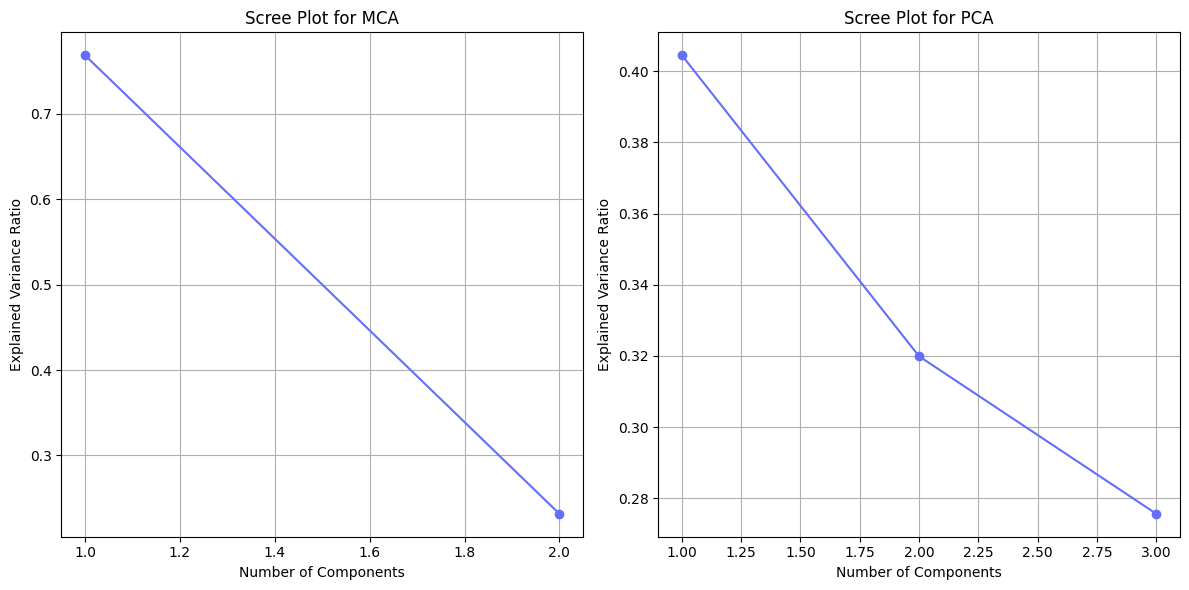

In [148]:

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Extract the eigenvalues from MCA
mca_eigenvalues = mca.eigenvalues_

# Calculate the proportion of explained variance
explained_variance_ratio = mca_eigenvalues / mca_eigenvalues.sum()
# Scree plot for MCA
axes[0].plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-',color=color_cont[0])
axes[0].set_title('Scree Plot for MCA')
axes[0].set_xlabel('Number of Components')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].grid()

PC_values = np.arange(pca.n_components_) + 1

# Scree plot for PCA
axes[1].plot(PC_values, pca.explained_variance_ratio_, marker='o', linestyle='-',color=color_cont[0])
axes[1].set_title('Scree Plot for PCA')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Explained Variance Ratio')
axes[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()


In [149]:

# Perform MCA for categorical variables
mca = MCA(n_components=3)
X_mca = mca.fit_transform(df_subset[categorical_columns])

# Perform PCA for numerical variables after scaling
scaler = StandardScaler()
numerical_data_scaled = scaler.fit_transform(df_subset[numerical_columns])

pca = PCA(n_components=3)
X_pca= pca.fit_transform(numerical_data_scaled)

# Combine results if necessary
X = np.concatenate((X_mca, X_pca), axis=1)


# Model Building and Evaluation

In [150]:

n_clusters=2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y = kmeans.fit_predict(X)

df_clusters['Predicted Labels'] =y




/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



<Axes: ylabel='count'>

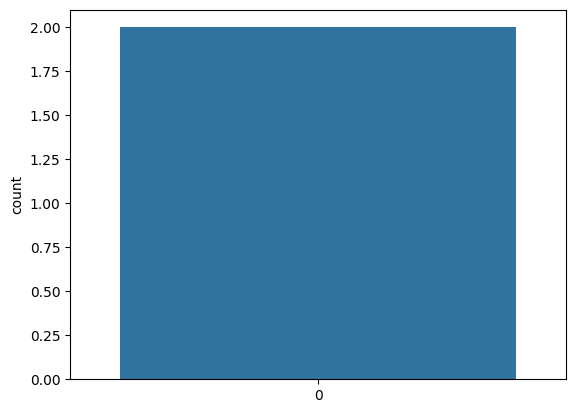

In [151]:
sns.countplot(df_clusters['Predicted Labels'].value_counts())

In [152]:
df_clusters['Predicted Labels'].value_counts()

Predicted Labels
0    4719
1    1776
Name: count, dtype: int64

**Note:** Due to class imbalances we will use F1 SCORE for scoring strategy in our supervzed model training.

In [153]:
# Create a Random Forest model
rf_model = RandomForestClassifier(random_state=42)  # You can adjust hyperparameters as needed

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X, y, cv=5,scoring='f1')  # Adjust the number of folds (cv) as needed

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)

# Calculate the mean and standard deviation of the scores
print("Mean CV Score:", cv_scores.mean())
print("Standard Deviation of CV Scores:", cv_scores.std())

Cross-Validation Scores: [0.98748261 0.94878706 0.98435277 0.97988506 0.87835703]
Mean CV Score: 0.9557729076101655
Standard Deviation of CV Scores: 0.04109922187333182


In [154]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
random_forest = RandomForestClassifier( random_state=42)  # You can adjust hyperparameters


# Define the hyperparameters and their respective values to search over
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required to be a leaf node
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1,scoring='f1')

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Initialize a Random Forest model with the best hyperparameters
best_random_forest = RandomForestClassifier(random_state=42, **best_params)

# Train the model
best_random_forest.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_random_forest.predict(X_test)

# Evaluate the model with the best hyperparameters
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Accuracy: {accuracy:.2f}")

# You can also print the best hyperparameters if needed
print("Best Hyperparameters:", best_params)

classification_report=classification_report(y_test,y_pred)
print("Classification Report:")
print(classification_report)
confusion_mat = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(confusion_mat)



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Accuracy: 0.99
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       935
           1       0.99      0.97      0.98       364

    accuracy                           0.99      1299
   macro avg       0.99      0.98      0.99      1299
weighted avg       0.99      0.99      0.99      1299

Confusion Matrix:
[[931   4]
 [ 10 354]]


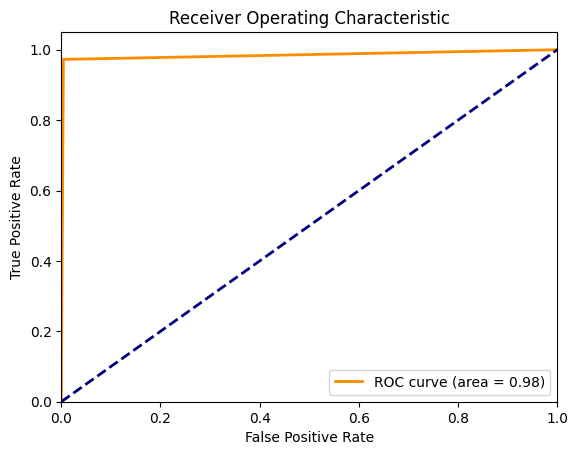

In [155]:

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


## Saving the final predictions and model

In [156]:
df_clusters[df_clusters['Match ID'] == 9][['Match ID','Result','Player','Batting Performance','Bowling Performance','Fielding Performance','Predicted Labels']]

,Match ID,Result,Player,Batting Performance,Bowling Performance,Fielding Performance,Predicted Labels
852,9,1.0,SR Tendulkar,39.0,0.060606,1,1
1065,9,1.0,Yuvraj Singh,41.0,0.062500,0,0
1583,9,1.0,R Dravid,58.0,NaN,0,1
1960,9,1.0,SC Ganguly,70.5,0.166667,1,1
3760,9,1.0,AB Agarkar,1.0,0.000000,0,0
4086,9,1.0,Z Khan,1.0,0.071429,0,0
4595,9,1.0,RR Singh,0.0,0.000000,0,0
4706,9,1.0,A Kumble,1.0,0.068966,0,0
5020,9,1.0,V Dahiya,1.0,NaN,3,1
5177,9,1.0,VG Kambli,0.0,NaN,0,0


In [157]:

# Step 1: Filter rows with predicted_labels equal to 0
filtered_df = df_clusters

# Step 2: Group by 'Match ID'
grouped_df = filtered_df.groupby('Match ID')

# Step 3: Sort within each group by performance metrics
sorted_df = grouped_df.apply(lambda group: group.sort_values(by=['Batting Performance', 'Bowling Performance', 'Fielding Performance'], ascending=False))

# Reset the index to avoid the ambiguity error
sorted_df.reset_index(drop=True, inplace=True)

# Step 4: Select the top performer for each match
top_performers = sorted_df.groupby('Match ID').first().reset_index()

# Step 5: Create a DataFrame to store match ID, result, and top performer
result_df = top_performers[['Match ID', 'Result','Player','Opposition','Ground','Start Date', 'Runs Scored in Match','Wickets Taken in Match','Catches Taken in Match','Stumpings Made in Match']]
result_df.rename(columns={'Player': 'Top Performer'},inplace=True)

# If there are no top performers for a match, set 'Top Performer' to 'NA'
result_df['Top Performer'].fillna('NA', inplace=True)
result_df['Result'] = df['Result'].apply(lambda x: 'won' if x == 1 else ('lost' if x == 0 else 2))

# Display the result DataFrame
result_df=result_df.sort_values(by='Start Date')


/tmp/ipykernel_32/1535681698.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_32/1535681698.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_32/1535681698.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [158]:
# Display the result DataFrame
result_df.tail(10)

,Match ID,Result,Top Performer,Opposition,Ground,Start Date,Runs Scored in Match,Wickets Taken in Match,Catches Taken in Match,Stumpings Made in Match
57,59,won,Shubman Gill,Bangladesh,Colombo (RPS),2023-09-15,121,1.0,0.0,0.0
56,58,NaN,Shubman Gill,Sri Lanka,Colombo (RPS),2023-09-17,27,3.0,0.0,0.0
55,57,won,Shubman Gill,Australia,Mohali,2023-09-22,74,1.0,2.0,0.0
54,56,won,SS Iyer,Australia,Indore,2023-09-24,105,3.0,0.0,0.0
53,55,won,RG Sharma,Australia,Rajkot,2023-09-27,81,0.0,0.0,0.0
52,54,lost,V Kohli,Australia,Chennai,2023-10-08,85,1.0,2.0,0.0
51,53,won,RG Sharma,Afghanistan,Delhi,2023-10-11,131,4.0,0.0,0.0
50,52,won,RG Sharma,Pakistan,Ahmedabad,2023-10-14,86,2.0,0.0,0.0
49,51,won,Shubman Gill,Bangladesh,Pune,2023-10-19,53,0.0,2.0,0.0
48,50,lost,V Kohli,New Zealand,Dharamsala,2023-10-22,95,0.0,2.0,0.0


In [159]:
import joblib

# Save the trained Random Forest model
model_filename = 'trained_rf_model.pkl'
joblib.dump(best_random_forest, model_filename)

# Save the Standard Scaler, PCA, MCA, or any other required utilities
scaler_filename = 'standard_scaler.pkl'
joblib.dump(scaler, scaler_filename)

pca_filename = 'pca.pkl'
joblib.dump(pca, pca_filename)

mca_filename = 'mca.pkl'
joblib.dump(mca, mca_filename)

# You can add more utility filenames and save other necessary objects

# Save the list of feature names for reference
features_filename = 'feature_names.pkl'
joblib.dump(df_subset.columns, features_filename)


['feature_names.pkl']

In [160]:
result_df.to_csv("Predictions.csv")

In [161]:
!zip -r output.zip .

  adding: trained_rf_model.pkl (deflated 80%)
  adding: .virtual_documents/ (stored 0%)
  adding: standard_scaler.pkl (deflated 34%)
  adding: pca.pkl (deflated 32%)
  adding: mca.pkl (deflated 88%)
  adding: Predictions.csv (deflated 75%)
  adding: feature_names.pkl (deflated 33%)


In [162]:
from IPython.display import FileLink
FileLink(r'output.zip')

/kaggle/working/output.zip